In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.client import device_lib

print(f"Using: {device_lib.list_local_devices()[-1].physical_device_desc}")
print(f"Tensorflow v{tf.__version__}")

Using: device: 0, name: NVIDIA GeForce 920MX, pci bus id: 0000:01:00.0, compute capability: 5.0
Tensorflow v2.5.0


In [3]:
batch_size = 64
img_height = 180
img_width = 180
validation_split = 0.2
seed = 42

In [4]:
data_dir = "data/"

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      directory=data_dir,
      validation_split=validation_split,
      subset="training",
      seed=seed,
      image_size=(img_height, img_width),
      batch_size=batch_size
)

Found 6899 files belonging to 8 classes.
Using 5520 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      directory=data_dir,
      validation_split=validation_split,
      subset="validation",
      seed=seed,
      image_size=(img_height, img_width),
      batch_size=batch_size
)

Found 6899 files belonging to 8 classes.
Using 1379 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


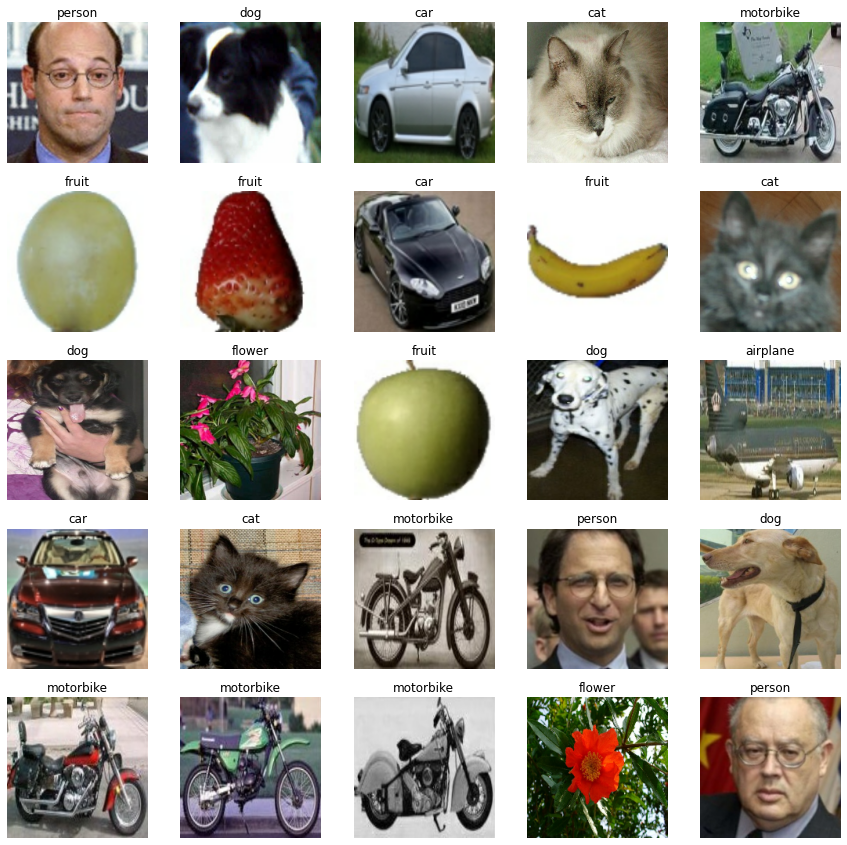

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 180, 180, 3)
(64,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
num_classes = len(class_names)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(48, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 48)        13872     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        27712     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [15]:
epochs = 10
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
87/87 [==============================] - 90s 610ms/step - loss: 0.8848 - accuracy: 0.6772 - val_loss: 0.3955 - val_accuracy: 0.8622
Epoch 2/10
87/87 [==============================] - 41s 469ms/step - loss: 0.3004 - accuracy: 0.8841 - val_loss: 0.3125 - val_accuracy: 0.8825
Epoch 3/10
87/87 [==============================] - 39s 453ms/step - loss: 0.2285 - accuracy: 0.9125 - val_loss: 0.3109 - val_accuracy: 0.8883
Epoch 4/10
87/87 [==============================] - 39s 451ms/step - loss: 0.1265 - accuracy: 0.9531 - val_loss: 0.2572 - val_accuracy: 0.9043
Epoch 5/10
87/87 [==============================] - 40s 461ms/step - loss: 0.0857 - accuracy: 0.9710 - val_loss: 0.3370 - val_accuracy: 0.8985
Epoch 6/10
87/87 [==============================] - 40s 462ms/step - loss: 0.0577 - accuracy: 0.9784 - val_loss: 0.3433 - val_accuracy: 0.8970
Epoch 7/10
87/87 [==============================] - 40s 462ms/step - loss: 0.0533 - accuracy: 0.9822 - val_loss: 0.3081 - val_accuracy: 0.9202

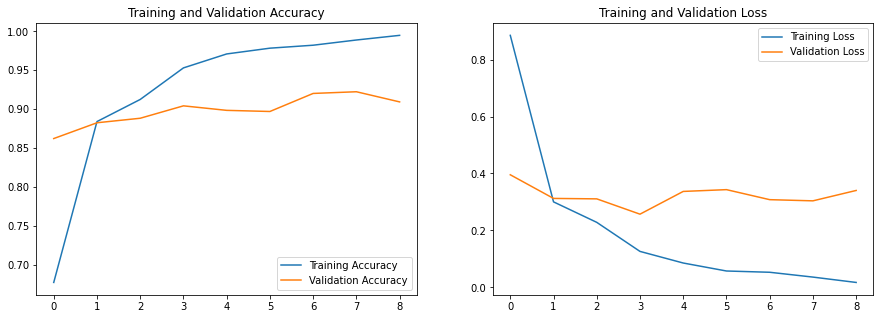

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(9)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to flower with a 100.00 percent confidence.


In [19]:
model.save("model.h5")